# Example of a workflow building for large sample

When a star has multiple observations, it is useful to make a loop over all of the spectra files rather than running each one individually. To obtain LSD profiles and $B_z$ values, only one cleaned line mask is necessary since all the spectra files are from the same star. With the cleaned mask and .s files, you must loop over the `run_lsdpy` function to calculate outputs for each input spectra file.

In the below tutorial, we will walk through how to calculate data from multiple spectra files for the same star. It is recomended you first look through the [tutorial for analyzing one obesrvation](OneObservationFlow_Tutorial.ipynb) for additional background on individual steps. We have provided three spectra files: hd46328_test_1.s, hd46328_test_2.s, and hd46328_test_3.s for $\xi^1$ CMa (HD 46328; [Erba et al. 2021](https://doi.org/10.1093/mnras/stab1454)) and the long list (LongList_T27000G35.dat) from the Vienna Atomic Line Database (VALD; [Ryabchikova et al. 2015](https://ui.adsabs.harvard.edu/abs/2015PhyS...90e4005R/abstract)).

First import `specpolFlow` and any other packages

In [1]:
import pandas as pd
import specpolFlow as pol

import copy
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## 1. Creating & Cleaning LSD Line Mask

Below, we specify the name of the VALD long list (only one is needed since all observations are for the same star) and the name and location of our created mask. Next, we remove regions 100 km $\text{s}^{-1}$ (specific to this example) around the Balmer series and Balmer gap. 

In [2]:
# making the mask file from the VALD line list
lineList_filename = 'OneObservationFlow_tutorialfiles/LongList_T27000G35.dat'
full_mask_filename = 'OneObservationFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask'
mask = pol.make_mask(lineList_filename, full_mask_filename, depthCutoff = 0.02, atomsOnly = True)

# using default regions for cleaning
velrange = 100
ExcludeRegions = pol.get_Balmer_regions_default(velrange) + pol.get_telluric_regions_default()

# cleaning and saving the mask
clean_mask_filename = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'
mask.clean(ExcludeRegions).save(clean_mask_filename)

# optionally, you can interactively clean lines from the line mask with
# pol.cleanMaskUI(full_mask_filename, observation_filename, clean_mask_filename)

missing Lande factors for 160 lines (skipped) from:
['He 2', 'O 2']
skipped all lines for species:
['H 1']


## 2. Create LSD Profile

Here, we create the LSD files for all three spectra file by looping over the file names.

In [3]:
# creating a template for the filenames
obsfile = 'OneObservationFlow_tutorialfiles/hd46328_test_{}.s'
lsdfile = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'

for i in range(0,3):
    # here we generate file names from a template
    # you could alternatively iterate over a list of filenames
    lsd, mod = pol.run_lsdpy(obs = obsfile.format(i+1), 
            mask = clean_mask_filename, outName = lsdfile.format(i+1), 
            velStart = - 100.0, velEnd = 100.0, velPixel = 2.6, 
            normDepth = 0.2, normLande = 1.2, normWave = 500.0,
            fLSDPlotImg=0)

Modified line mask, removed 75 too closely spaced lines
Average observed spec velocity spacing: 1.808983 km/s
using a 78 point profile with 2.600000 km/s pixels
mean mask depth 0.103397 wl 493.199 Lande 1.182459 (from 1047 lines)
mean mask norm weightI 0.516987 weightV 0.490160
saving model spectrum to  ...
I reduced chi2 429.9520 (chi2 33840233.42 constraints 78785 dof 78)
 Rescaling error bars by: 20.735284
V reduced chi2 1.1238 (chi2 88450.48 constraints 78785 dof 78)
 Rescaling error bars by: 1.060092
 removing profile continuum pol: -8.1249e-06 +/- 8.2428e-09 (avg err 9.0520e-05)
N1 reduced chi2 1.1036 (chi2 86861.21 constraints 78785 dof 78)
 Rescaling error bars by: 1.050525
 removing profile continuum pol: -1.3950e-06 +/- 8.0947e-09 (avg err 8.9703e-05)
line range estimate -14.200000000000188 42.99999999999969 km/s
V in line reduced chi^2 92.875851 (chi2 2043.268716) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced chi^2 1.64918

We can also output a .pdf with all the LSD plots for each observation which is useful for ensuring that the LSD profiles look as expected. 

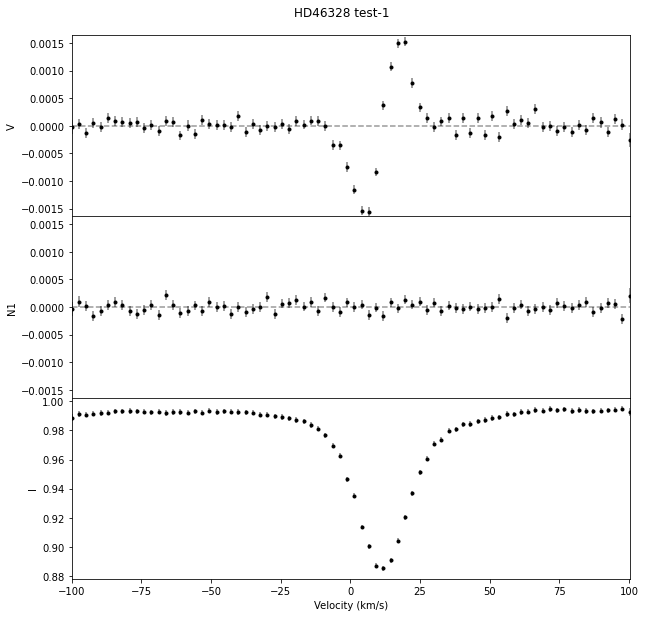

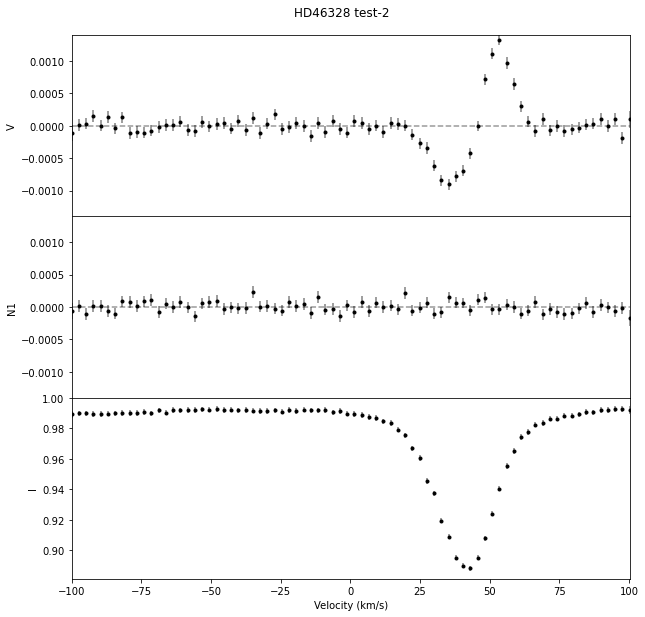

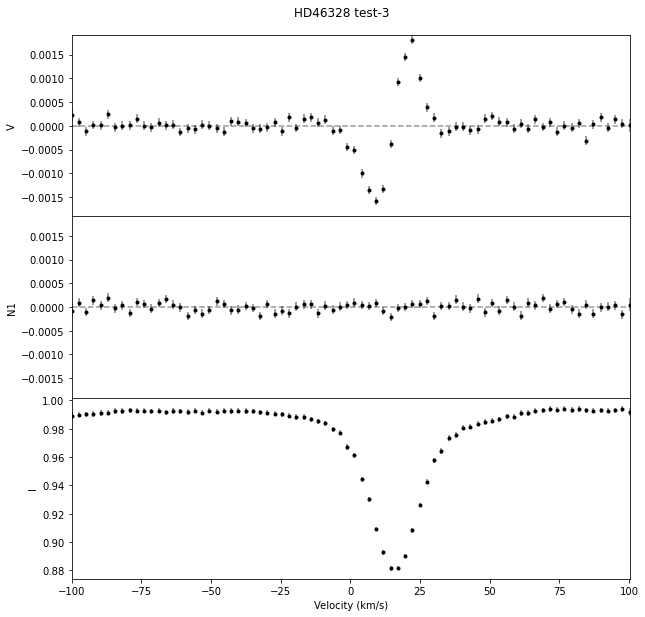

In [4]:
with PdfPages('OneObservationFlow_tutorialfiles/test_output/hd46328_test.pdf') as pdf:

    lsdfile = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'

    for i in range(0,3):

        lsd = pol.read_lsd(lsdfile.format(i+1))
        fig, ax = lsd.plot()

        fig.suptitle('HD46328 test' + '-'+ str(i+1), y = 0.92)
        pdf.savefig(fig)

## 3. Bz Calculation

We can then repeat the above steps for the Bz calculation. Note that each observation has a different radial velocity. One method to resolve this is to make a `vrad` list and put that inside the loop as done below. 

In [5]:
# Bz calculation using manual cog selection
star = 'hd46328'
vsini = 20
vrad = [12, 42, 16]

Bz_list = []
for i in range(3):
    lsdpath = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'
    velrange = [vrad[i]-30, vrad[i]+30]
    bzwidth = 20
    lsd = pol.read_lsd(lsdpath.format(i+1))
    
    Bz = lsd.calc_bz(cog = 'I', velrange = velrange, plot = False, bzwidth = bzwidth)
    Bz_list += [Bz]
    
for Bz in Bz_list:
    print('V bz (G)', Bz['V bz (G)'], ' V bz sig (G)', Bz['V bz sig (G)'], ' V FAP', Bz['V FAP'])

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
V bz (G) -114.81548297369285  V bz sig (G) 4.910790155719071  V FAP 0.0
V bz (G) -114.68157502794334  V bz sig (G) 5.19882079315512  V FAP 0.0
V bz (G) -105.49863227107238  V bz sig (G) 5.042137716559499  V FAP 0.0


Often times we also want to output a single table of all the Bz outputs for each observation rather than a different table for each observation. This can be done conveinently with pandas. Below is a single output table with the Bz outputs for every observation in the loop.

In [6]:
# Bz calculation using manual cog selection
star = 'hd46328'
vsini = 20
vrad = vrad = [12, 42, 16]

start = 0
for i in range(3):
    lsdpath = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'
    velrange = [vrad[i]-30, vrad[i]+30]
    bzwidth = 20
    lsd = pol.read_lsd(lsdpath.format(i+1))
    Bz = lsd.calc_bz(cog = 'I', velrange = velrange, plot = False, bzwidth = bzwidth)
    Bz = pd.DataFrame.from_dict(Bz, 'index').T
    Bz.insert(0, "Star", star, True)
    if start == 0:
        Bz_table = copy.copy(Bz)
        start = 1
    else:
        Bz_table = pd.concat([Bz_table, Bz], ignore_index = True)

Bz_table

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


,Star,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,hd46328,0.992552,11.842090,-8.157910,31.842090,-114.815483,4.910790,0.0,-4.336335,4.797427,0.340356,0.0,0.0,0.0
1,hd46328,0.991432,41.339359,21.339359,61.339359,-114.681575,5.198821,0.0,-0.722152,5.107832,0.463876,0.0,0.0,0.0
2,hd46328,0.992430,16.414456,-3.585544,36.414456,-105.498632,5.042138,0.0,2.778290,4.911537,0.214058,0.0,0.0,0.0


As before, we can also make a .pdf for all the Bz plots.

In [7]:
%%capture
start = 0
with PdfPages('OneObservationFlow_tutorialfiles/test_output/hd46328_test_Bz.pdf') as pdf:

    # Bz calculation using manual cog selection
    star = 'hd46328'

    vsini = 20
    vrad = vrad = [12, 42, 16]

    for i in range(3):
        lsdpath = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'
        velrange = [vrad[i]-30, vrad[i]+30]
        bzwidth = 20
        lsd = pol.read_lsd(lsdpath.format(i+1))
        Bz, fig = lsd.calc_bz(cog = 'I', velrange = velrange, plot = True, bzwidth = bzwidth)
        
        Bz = pd.DataFrame.from_dict(Bz, 'index').T
        Bz.insert(0, "Star", star, True)
        if start == 0:
            Bz_table = copy.copy(Bz)
            start = 1
        else:
            Bz_table = pd.concat([Bz_table, Bz], ignore_index = True)
        fig.suptitle('{} - {}'.format(star,i+1), fontsize = 20, y = 0.92)
        
        pdf.savefig(fig)
